In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
themes = get_themes()
set_nb_theme(themes[1])

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from xgboost import XGBRegressor
from sortedcontainers import SortedSet
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn,xgboost,sortedcontainers

Ethen 2017-03-14 17:49:51 

CPython 3.5.2
IPython 4.2.0

numpy 1.12.0
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18
xgboost 0.6
sortedcontainers 1.5.7


/Users/ethen/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We first did some data cleaning to make it suitable more modelling purposes. Namely, we dropped 12 rows from the data due to the fact that they had missing values in the following 6 fields. 'num-of-doors', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price'. This choice was made because there wasn't that many rows that were dropped during this process leaving us still with a reasonable amount of the data to work with. Thus no imputation of these missing values were done to prevent biasing the data. Next, we completely removed the field 'normalized-losses' due to lots of missing values (20% of the data was missing). And we also dropped the column 'make' because it has too many distinct categorical values. This kind of phenomenon can cause issues for various modelling techniques.

In [3]:
def read_dataset(filename):
    """
    pass in the filename and read in the dataset, if the dataset is
    not found in the current folder, we will fetch it from the website
    """
    if not os.path.exists(filename):
        url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
        df = pd.read_csv(url, header = None, na_values = ['?'])
        colnames = ['symboling', 'normalized-losses', 'make', 'fuel-type', 
                    'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 
                    'engine-location', 'wheel-base', 'length', 'width', 'height',
                    'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size',
                    'fuel-system', 'bore', 'stroke', 'compression-ratio',
                    'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
        df.columns = colnames
        df.to_csv(filename, index = False)

    df = pd.read_csv(filename)
    return df


def preprocess(df):
    """preprocessing steps specific to the car dataset"""
    # there were very few missing records for these columns, thus
    # we drop them to prevent biasing the data with imputation 
    # (only 12 rows were removed)
    subset = ['num-of-doors', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']
    df = df.dropna(subset = subset)

    # normalized-losses, drop due to lots of missing values
    # make drop due to having too many distinct categorical variables
    df = df.drop(['normalized-losses', 'make'], axis = 1)
    
    # extract the response/output column
    response_col = 'price'
    y = df[response_col].values
    df = df.drop(response_col, axis = 1)
    
    # categorical variables: one-hot-encode them
    # the numeric variables are the columns excluding 
    # the categorical variables and the variables that 
    # have been detected to have multicollinearity using 
    # VIF (variance inflation factor)
    cat_cols = ['symboling', 'fuel-type', 'aspiration', 'num-of-doors', 
                'body-style', 'drive-wheels', 'engine-location', 'fuel-system',
                'engine-type', 'num-of-cylinders']
    for col in cat_cols:
        df[col] = df[col].astype('category')
        
    dummied = pd.get_dummies(df[cat_cols], drop_first = True)
    
    # use sorted set to ensure the consistency of the column order
    collinear_cols = SortedSet(['city-mpg', 'curb-weight', 'horsepower', 'length', 'width'])
    num_cols = list(SortedSet(df.columns) - SortedSet(cat_cols) - collinear_cols)
    X = pd.concat([df[num_cols], dummied], axis = 1)
    
    # standardize the numeric columns using the training set
    X_train, X_test, y_train, y_test = train_test_split(X.values, y, 
                                                        test_size = 0.2, 
                                                        random_state = 4321)
    scaler = StandardScaler()
    X_train[:, :len(num_cols)] = scaler.fit_transform(X_train[:, :len(num_cols)])
    X_test[:, :len(num_cols)] = scaler.transform(X_test[:, :len(num_cols)])
    return X_train, X_test, y_train, y_test, X.columns

In [4]:
filename = 'auto.csv'
df = read_dataset(filename)
X_train, X_test, y_train, y_test, feature_names = preprocess(df)

In [5]:
xgboost_reg = XGBRegressor(max_depth = 3, n_estimators = 300)
xgboost_reg.fit(X_train, y_train)
y_pred = xgboost_reg.predict(X_test)
r2_score(y_test, y_pred)

0.94114981068390713

In [6]:
def plot_xgboost_importance(xgboost_model, feature_names, threshold = 5):
    """
    Improvements on xgboost's plot_importance function, where 
    1. the importance are scaled relative to the max importance, and 
    number that are below 5% of the max importance will be chopped off
    2. we need to supply the actual feature name so the label won't 
    just show up as feature 1, feature 2, which are not very interpretable
    
    returns the important features's index sorted in descending order
    """
    # convert from dictionary to tuples and sort by the
    # importance score in ascending order for plotting purpose
    importance = xgboost_model.booster().get_score(importance_type = 'gain')
    tuples = [( int(k[1:]), importance[k] ) for k in importance]
    tuples = sorted(tuples, key = itemgetter(1))
    labels, values = zip(*tuples)

    # make importances relative to max importance,
    # and filter out those that have smaller than 5%
    # relative importance (threshold chosen arbitrarily)
    labels, values = np.asarray(labels), np.asarray(values)
    values = np.round(100 * values / np.max(values), 2)
    mask = values > threshold
    labels, values = labels[mask], values[mask]
    feature_labels = feature_names[labels]
    
    ylocs = np.arange(values.shape[0])
    plt.barh(ylocs, values, align = 'center')
    for x, y in zip(values, ylocs):
        plt.text(x + 1, y, x, va = 'center')

    plt.ylabel('Features')
    plt.xlabel('Relative Importance Score')
    plt.title('Feature Importance Score')
    plt.xlim([0, 110])
    plt.yticks(ylocs, feature_labels)
    
    # revert the ordering of the importance
    return labels[::-1]

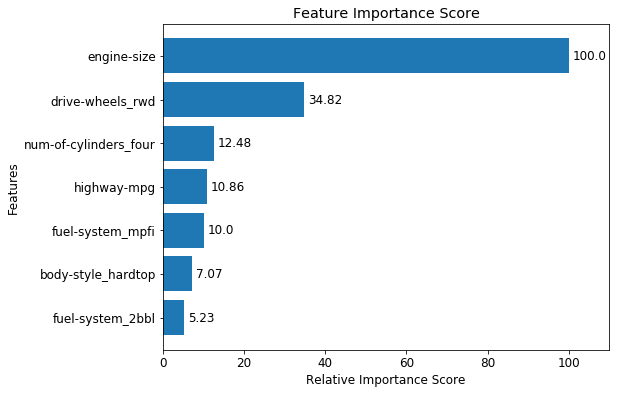

In [7]:
# change default figure and font size
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 8, 6
important_labels = plot_xgboost_importance(xgboost_reg, feature_names)

Looking at the plot, we can see that the two most importance factors that were most indicative of the car price was engine-size then comes drive-wheels_rwd (Rear-wheel drive). Explicitly, the bigger the engine size the more expensive the car and if the car is a Rear-wheel drive the more expensive the car. 

On the other hand, the third most important feature says, the smaller the number of cylinders that the car has the cheaper the car will be. But based on the model's output, this feature already has a very low predictive power on the car price. Thus it is ill-advised to dwindle on this feature.

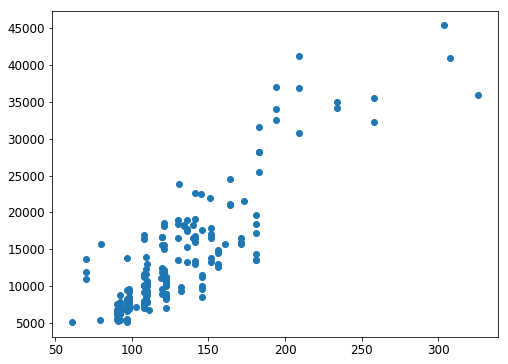

In [16]:
plt.scatter(df['engine-size'], df['price'])
plt.show()

In [8]:
df.groupby('num-of-cylinders')['price'].mean()

num-of-cylinders
eight     38900.000000
five      22007.600000
four      10303.197452
six       23671.833333
three      5151.000000
twelve    36000.000000
two       13020.000000
Name: price, dtype: float64

In [9]:
df.groupby('drive-wheels')['price'].mean()

drive-wheels
4wd    10241.000000
fwd     9244.779661
rwd    19757.613333
Name: price, dtype: float64

In [10]:
from math import ceil

def partial_dependence_plot(model, data, important_labels, feature_names):
    """one size fits all partial dependence plot for any regression model"""
    n_plots_per_row = 3
    n_plots = ceil(important_labels.shape[0] / n_plots_per_row) 
    
    for plot_index, x_index in enumerate(important_labels, 1):
        target = X_train[:, x_index]
        unique_target = np.unique(target)
        n_unique = unique_target.shape[0]

        is_categorical = n_unique == 2
        if is_categorical:
            x_points = unique_target
            y_points = np.zeros_like(unique_target)
        else:
            # for numeric values, generate a fix number of values
            # in between the min and max value of the target column
            n_points = min(n_unique, 50)
            x_points = np.linspace(np.min(target), np.max(target), n_points)
            y_points = np.zeros_like(x_points)    

        for i in range(x_points.shape[0]):
            x_data = data.copy()
            x_data[:, x_index] = x_points[i]
            y_pred = model.predict(x_data)
            y_points[i] = np.mean(y_pred)
        
        plt.subplot(n_plots, n_plots_per_row, plot_index)
        if is_categorical:
            plt.bar(x_points, y_points)
        else:
            plt.plot(x_points, y_points)
        
        plt.title(feature_names[x_index])
            
    plt.tight_layout()

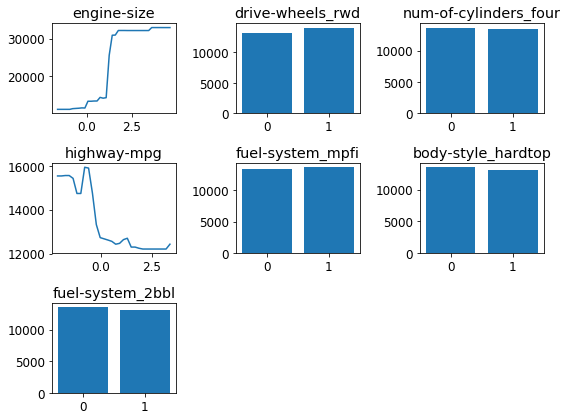

In [12]:
partial_dependence_plot(model = xgboost_reg,
                        data = X_train,
                        important_labels = important_labels, 
                        feature_names = feature_names)

For future work, we can try tweaking the model's hyperparameter or different modelling techniques to see if leads to a better performance. And there are also ways to deal with columns that have lots of missing values and too many distinct categorical values. By exploring it, we can see if incorporating the field 'normalized-losses' and 'make' will make a huge impact on the model's performance.